In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

# Pretty display for notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Porto training dataset
data = pd.read_csv('creditcard.csv')

# Success
print "This dataset has {} data points with {} variables each.".format(*data.shape)

y=data['Class']
X = data.drop('Class', axis = 1)

print X.shape
print y.shape

data.info() #identify if there are any null values
data.keys() #identify the columns

This dataset has 284807 data points with 31 variables each.
(284807, 30)
(284807,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-nul

Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')

In [4]:
y=data['Class']
X=data.drop(['Class','Time'],axis = 1) #drop time class since the fraud transactions are not connected
percent_fraud = 100*float(np.sum(y))/len(X)
print "{0:0.4f} % of the dataset are fraudulent transactions".format(percent_fraud)

# pre-process the data to make it usable
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X = scaler.fit_transform(X)

0.1727 % of the dataset are fraudulent transactions


In [62]:
# intermediate code to find highest value of amounts tagged as fraud
high_fraud_amounts = data.loc[data['Class']==1].sort_values(by=['Amount'],ascending=False)
high_fraud_amounts = high_fraud_amounts['Amount']
display(high_fraud_amounts.head())

176049    2125.87
6971      1809.68
249167    1504.93
89190     1402.16
81609     1389.56
Name: Amount, dtype: float64

##Visualization and Exploration
#Next, we will visualize the data to explore it before doing any classification

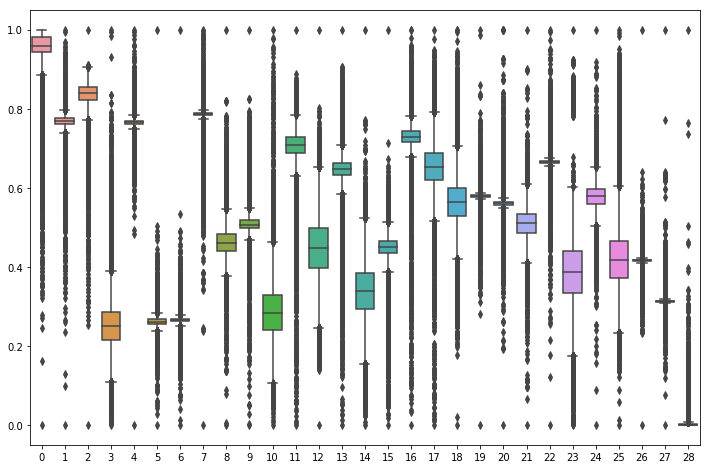

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
sns.boxplot(data=X)

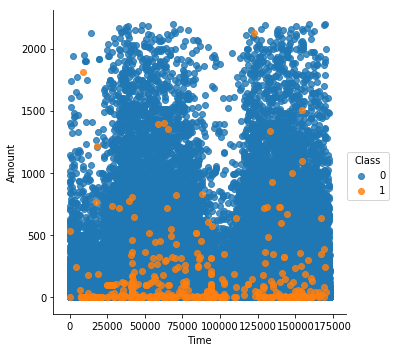

In [8]:
amount_class_df=data[['Amount','Time','Class']].loc[data['Amount']<2200.]
sns.lmplot(x='Time', y='Amount', data=amount_class_df,fit_reg=False,hue='Class')
#sns.lmplot(x='Time', y='V1', data=data,fit_reg=False,hue='Class')

Interesting to note that there is no fraud for amounts greater than about $ 2,300.

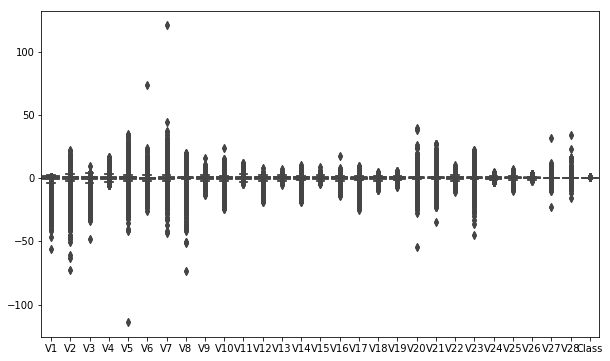

In [18]:
#violin plot for V1 to V28
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
feature_data=data.drop(['Amount','Time'],axis=1)
sns.boxplot(data=feature_data)
scaled_feature_data=scaler.fit_transform(feature_data)
sns.boxplot(data=scaled_feature_data)
sns.boxplot(data=feature_data)

sns.set_style('whitegrid')
sns.violinplot(x='Type 1', y='Class', data=df)

##Apply Classifiers to the dataset

In [33]:
# Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a classifier and fit it to the training set
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
rand_clf = RandomForestClassifier(random_state=42)
rand_clf.fit(X_train,y_train)
rand_y_pred= rand_clf.predict(X_test)
rand_y_pred_proba = rand_clf.predict_proba(X_test)

ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train,y_train)
ada_y_pred= ada_clf.predict(X_test)
ada_y_pred_proba= ada_clf.predict_proba(X_test)

from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=10,random_state=42) # avoid overfitting
dectree_clf.fit(X_train,y_train)
dectree_y_pred= dectree_clf.predict(X_test)
dectree_y_pred_proba= dectree_clf.predict_proba(X_test)

from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)
nb_y_pred= nb_clf.predict(X_test)
nb_y_pred_proba= nb_clf.predict_proba(X_test)

import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
xgboost_y_pred = gbm.predict(X_test)
xgboost_y_pred_proba = gbm.predict_proba(X_test)

In [94]:
# Report the prediction scores and plot precision recall curve for various classifiers
from sklearn.metrics import average_precision_score,recall_score,precision_recall_curve,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def draw_precision_recall(clf,X,y):
    i=0
    
    n_folds=5

    cv=StratifiedKFold(n_splits=n_folds)
    for train,test in cv.split(X,y):
        clf.fit(X[train], y[train])
        y_probas_ = clf.predict_proba(X[test])
        y_pred=clf.predict(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], y_probas_[:, 1],pos_label=1)
        av_precision=average_precision_score(y[test], y_pred)
        label_text = "PR fold {fold:1d} AP = {ap:0.4f}".format(fold=i,ap=av_precision)
        plt.plot(recall, precision, lw=1, label=label_text)
        i+=1
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')

def draw_roc_curve(classifier,X,y,n_folds=6,pos_label=1):
    # Compute ROC curve and area for the curve
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv=StratifiedKFold(n_splits=n_folds)
    for i,(train, test) in enumerate(cv.split(X,y)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def feature_importance_graph(trained_clf):
    importances = trained_clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')

def output_classifier_score(clf_name,y_test,y_pred,y_pred_proba):
    print clf_name
    average_precision = average_precision_score(y_test, y_pred_proba[:, 1])
    print "Average Precision = {0:0.4f} Recall Score = {0:0.4f}".format(
        average_precision,recall_score(y_test,y_pred))
    target_names=['OK','Fraud']
    print classification_report(y_test, y_pred, target_names=target_names,digits=4)

Decision Tree
fbeta_score = 0.9954 AUC = 0.9954 Mathews Coeff = 0.9954
             precision    recall  f1-score   support

         OK     0.9972    0.9939    0.9955    283912
      Fraud     0.9939    0.9972    0.9955    284315

avg / total     0.9955    0.9955    0.9955    568227



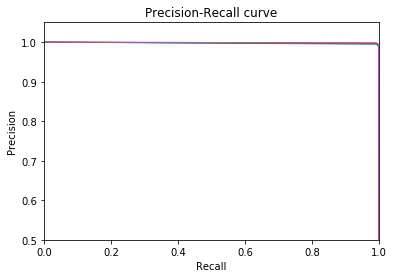

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
dectree_clf = DecisionTreeClassifier(min_samples_leaf=10,random_state=42)
draw_precision_recall(dectree_clf,X,y)
#draw_roc_curve(dectree_clf,X,y)
beta=0.9
y_pred = cross_val_predict(dectree_clf, X, y, cv=5)
classifier_scoring('Decision Tree',y,y_pred,beta)

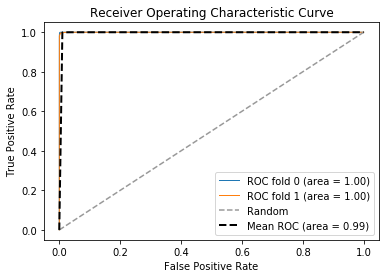

AttributeError: 'RandomForestClassifier' object has no attribute 'get_fscore'

In [97]:
from sklearn.ensemble import RandomForestClassifier
rand_clf = RandomForestClassifier(random_state=42)
#draw_precision_recall(rand_clf,X,y)
draw_roc_curve(rand_clf,X,y)
feature_importance_graph(rand_clf)

Naive_Bayes
Average Precision = 0.9567 Recall Score = 0.9567
             precision    recall  f1-score   support

         OK     0.8686    0.9752    0.9188     71030
      Fraud     0.9717    0.8525    0.9082     71027

avg / total     0.9202    0.9138    0.9135    142057

Decision Tree
Average Precision = 0.9978 Recall Score = 0.9978
             precision    recall  f1-score   support

         OK     0.9969    0.9959    0.9964     71030
      Fraud     0.9959    0.9969    0.9964     71027

avg / total     0.9964    0.9964    0.9964    142057

Random Forest
Average Precision = 1.0000 Recall Score = 1.0000
             precision    recall  f1-score   support

         OK     0.9999    0.9998    0.9999     71030
      Fraud     0.9998    0.9999    0.9999     71027

avg / total     0.9999    0.9999    0.9999    142057

Ada Boost
Average Precision = 0.9963 Recall Score = 0.9963
             precision    recall  f1-score   support

         OK     0.9523    0.9766    0.9643     71030
  

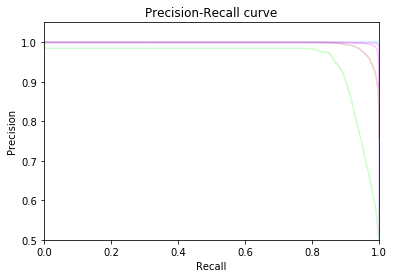

In [38]:
## Output scores for various classifiers
beta=2.0 # beta greater than 1 due to higher importance of recall vs. precision

for classifier_name,y_pred,y_pred_proba,pt_color in [('Naive_Bayes', nb_y_pred,nb_y_pred_proba,'lime'),
                                        ('Decision Tree',dectree_y_pred,dectree_y_pred_proba,'blueviolet'),
                                        ('Random Forest',rand_y_pred,rand_y_pred_proba,'dodgerblue'),
                                        ('Ada Boost',ada_y_pred,ada_y_pred_proba,'brown'),
                                        ('XGBoost',xgboost_y_pred,xgboost_y_pred_proba,'magenta')]:
    output_classifier_score(classifier_name,y_test,y_pred,y_pred_proba)
    draw_precision_recall(y_test,y_pred_proba)
    #draw_roc_curve(y_test,y_pred_proba)

Since XGBoost performs the best of all the classifiers, we will use this for further exploration. At this point, there are two approaches. The first is to explore data-based methods to improve the balance of the underlying dataset and see if that performs better. The second is to tune hyper-parameters of XGBoost.

In [22]:
# Explore data-based methods
from imblearn.over_sampling import RandomOverSampler
OverSampler=RandomOverSampler(random_state=42)
X_over,y_over = OverSampler.fit_sample(X, y)

from imblearn.under_sampling import RandomUnderSampler,NearMiss
UnderSampler=RandomUnderSampler(random_state=42)
X_under,y_under = UnderSampler.fit_sample(X, y)

NearMissSampler=NearMiss(random_state=42)
X_nearmiss,y_nearmiss = NearMissSampler.fit_sample(X, y)

from imblearn.combine import SMOTEENN
SMOTESampler=SMOTEENN(random_state=42)
X_smote,y_smote = SMOTESampler.fit_sample(X, y)

In [23]:
from sklearn.model_selection import train_test_split

for sampler_name,X,y in [('OverSampler',X_over,y_over),
                         ('UnderSampler',X_under,y_under),
                         ('NearMiss',X_nearmiss,y_nearmiss),
                        ('SMOTE ENN',X_smote,y_smote)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    gbm = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    y_pred_proba = gbm.predict_proba(X_test)
    output_classifier_score(sampler_name,y_test,y_pred,y_pred_proba)

OverSampler
Average Precision = 0.9998 Recall Score = 0.9998
             precision    recall  f1-score   support

         OK     1.0000    0.9976    0.9988     71023
      Fraud     0.9976    1.0000    0.9988     71135

avg / total     0.9988    0.9988    0.9988    142158

UnderSampler
Average Precision = 0.9799 Recall Score = 0.9799
             precision    recall  f1-score   support

         OK     0.8963    0.9603    0.9272       126
      Fraud     0.9550    0.8833    0.9177       120

avg / total     0.9249    0.9228    0.9226       246

NearMiss
Average Precision = 0.9783 Recall Score = 0.9783
             precision    recall  f1-score   support

         OK     0.9360    0.9286    0.9323       126
      Fraud     0.9256    0.9333    0.9295       120

avg / total     0.9309    0.9309    0.9309       246

SMOTE ENN
Average Precision = 0.9997 Recall Score = 0.9997
             precision    recall  f1-score   support

         OK     0.9924    0.9921    0.9922     71030
      Fr

Clearly the SMOTE method of sampling performs best - this is a mix of both under and oversampling

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 300, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter=8)
optimized_GBM.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [10]:
optimized_GBM.cv_results_

{'mean_fit_time': array([  145.41872845,  2450.7132237 ,   159.90643997,   122.75398078,
           86.49034739,    82.06357098,   128.06235576,   121.28832679]),
 'mean_score_time': array([ 0.60759292,  0.63611417,  0.38244042,  0.52046714,  0.3949842 ,
         0.3864171 ,  0.49506216,  0.53755603]),
 'mean_test_score': array([ 0.97920916,  0.97840549,  0.97847301,  0.97844255,  0.97959824,
         0.97979172,  0.97886214,  0.97844442]),
 'mean_train_score': array([ 1.        ,  1.        ,  0.99999237,  1.        ,  0.99997206,
         0.99999925,  0.99999877,  1.        ]),
 'param_max_depth': masked_array(data = [7 5 3 7 3 3 7 5],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 1 3 3 5 1 5 3],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 7, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 1}

In [12]:
beta=0.9
y_pred = optimized_GBM.predict(X_test)
classifier_scoring('XG Boost',y_test,y_pred,beta)

XG Boost
fbeta_score = 0.8833 AUC = 0.8833 Mathews Coeff = 0.8833
             precision    recall  f1-score   support

         OK     0.9997    0.9999    0.9998     71089
      Fraud     0.9485    0.8142    0.8762       113

avg / total     0.9996    0.9996    0.9996     71202



In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'learning_rate': [0.2, 0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 400, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter = 8)
optimized_GBM.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'subsample': [0.7, 0.8, 0.9], 'learning_rate': [0.2, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [6]:
optimized_GBM.cv_results_

NameError: name 'optimized_GBM' is not defined

In [17]:
xgdmat = xgb.DMatrix(X_train, y_train)

In [21]:
our_params = {'eta': 0.2, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Randomized Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['auc'],
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [23]:
cv_xgb.tail(10)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
125,0.980785,0.011138,0.999990,0.000006
126,0.980868,0.011030,0.999992,0.000005
127,0.980781,0.011115,0.999992,0.000005
128,0.980683,0.011229,0.999992,0.000005
129,0.980511,0.011681,0.999993,0.000004
130,0.980573,0.011688,0.999994,0.000004
131,0.980419,0.011755,0.999994,0.000004
132,0.980708,0.011924,0.999994,0.000004
133,0.980754,0.012024,0.999995,0.000003
134,0.981140,0.010975,0.999996,0.000003


In [24]:
our_params = {'eta': 0.2, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1}
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 134)

In [ ]:
import pickle
pickle.dump(model,open("xgb_fraud.pickle.dat"),"wb")

In [5]:
feature_importance_graph(final_gb)

NameError: name 'final_gb' is not defined

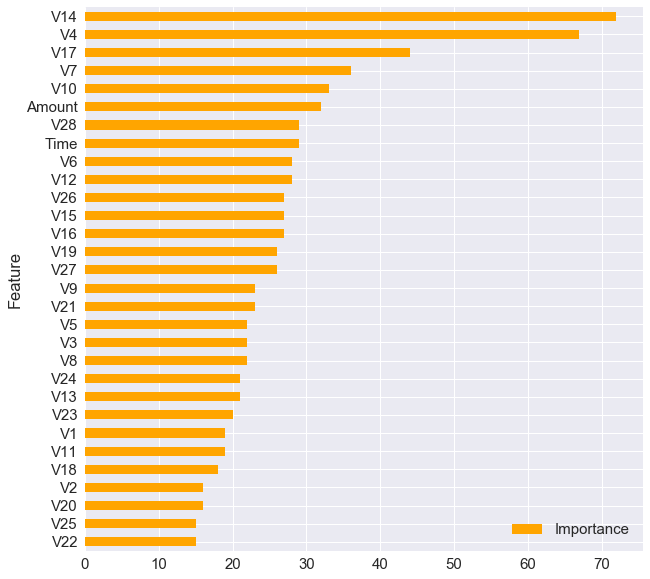

In [38]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')

In [36]:
testdmat = xgb.DMatrix(X_test)
y_pred_proba = final_gb.predict(testdmat)
y_pred[y_pred_proba > 0.5] = 1
y_pred[y_pred_proba <= 0.5] = 0
beta=0.9
classifier_scoring('Tuned XG Boost',y_test,y_pred,beta)

Tuned XG Boost
fbeta_score = 0.8780 AUC = 0.8780 Mathews Coeff = 0.8780
             precision    recall  f1-score   support

         OK     0.9997    0.9999    0.9998     71089
      Fraud     0.9574    0.7965    0.8696       113

avg / total     0.9996    0.9996    0.9996     71202



In [17]:
# Exploring cost-sensitive methods
# Create another feature by multiplying amount by the class
amount=data['Amount']
fraud=data['Class']
y = amount*fraud
X= data.drop(['Class','Time','Amount'],axis=1)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rand_clf = RandomForestRegressor(random_state=42)
rand_clf.fit(X_train,y_train)
rand_y_pred= rand_clf.predict(X_test)

threshold = 10.
rand_y_pred[rand_y_pred > threshold] = 1
rand_y_pred[rand_y_pred <= threshold] = 0

In [36]:
print rand_y_pred>0.
beta=0.9
classifier_scoring('Modified Classifier using RandomForestRegressor',y_test,rand_y_pred,beta)

[False False False ..., False False False]
Modified Classifier using RandomForestRegressor
fbeta_score = 0.0000 AUC = 0.0000 Mathews Coeff = 0.0000
             precision    recall  f1-score   support

         OK     0.9984    1.0000    0.9992     71089
      Fraud     0.0000    0.0000    0.0000       113

avg / total     0.9968    0.9984    0.9976     71202

